In [1]:
#@title Install requirements. { display-mode: "form" }
# Install requirements
%pip install torch transformers sentencepiece h5py

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
#@title Set up working directories and download files/checkpoints. { display-mode: "form" }
# Create directory for storing model weights (2.3GB) and example sequences.
# Here we use the encoder-part of ProtT5-XL-U50 in half-precision (fp16) as
# it performed best in our benchmarks (also outperforming ProtBERT-BFD).
# Also download secondary structure prediction checkpoint to show annotation extraction from embeddings

# !mkdir protT5 # root directory for storing checkpoints, results etc
# !mkdir protT5/protT5_checkpoint # directory holding the ProtT5 checkpoint
# !mkdir protT5/sec_struct_checkpoint # directory storing the supervised classifier's checkpoint
# !mkdir protT5/output # directory for storing your embeddings & predictions
# !wget -nc -P protT5/ https://rostlab.org/~deepppi/example_seqs.fasta
# !wget -nc -P protT5/sec_struct_checkpoint http://data.bioembeddings.com/public/embeddings/feature_models/t5/secstruct_checkpoint.pt

In [3]:
# In the following you can define your desired output. Current options:
# per_residue embeddings
# per_protein embeddings
# secondary structure predictions

# Replace this file with your own (multi-)FASTA
# Headers are expected to start with ">";
seq_path = "./protT5/example_seqs.fasta"

# whether to retrieve embeddings for each residue in a protein
# --> Lx1024 matrix per protein with L being the protein's length
# as a rule of thumb: 1k proteins require around 1GB RAM/disk
per_residue = False
per_residue_path = "./protT5/output/per_residue_embeddings.h5" # where to store the embeddings

# whether to retrieve per-protein embeddings
# --> only one 1024-d vector per protein, irrespective of its length
per_protein = True
per_protein_path = "./protT5/output/per_protein_embeddings.h5" # where to store the embeddings

# whether to retrieve secondary structure predictions
# This can be replaced by your method after being trained on ProtT5 embeddings
sec_struct = False
sec_struct_path = "./protT5/output/ss3_preds.fasta" # file for storing predictions

# make sure that either per-residue or per-protein embeddings are stored
assert per_protein is True or per_residue is True or sec_struct is True, print(
    "Minimally, you need to active per_residue, per_protein or sec_struct. (or any combination)")


In [4]:
#@title Import dependencies and check whether GPU is available. { display-mode: "form" }
from transformers import T5EncoderModel, T5Tokenizer
import torch
from torch import nn
import h5py
import time
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using cuda:0


In [5]:
#@title Network architecture for subcell. loc. prediction and Membrane-bound pred. { display-mode: "form" }
# Feed forward neural network to predict a) subcellular localization and 
# b) classifies membrane-bound from water-soluble proteins
class FNN( nn.Module ):
    
    def __init__( self ):
        super(FNN, self).__init__()
        # Linear layer, taking embedding dimension 1024 to make predictions:
        self.layer = nn.Sequential(
                        nn.Linear( 1024, 32),
                        nn.Dropout( 0.25 ),
                        nn.ReLU(),
                        )
        # subcell. classification head
        self.loc_classifier = nn.Linear( 32, 10)
        # membrane classification head
        self.mem_classifier = nn.Linear( 32,  2)

    def forward( self, x):
        # Inference
        out = self.layer( x ) 
        Yhat_loc = self.loc_classifier(out)
        Yhat_mem = self.mem_classifier(out)
        return Yhat_loc, Yhat_mem 

In [6]:
#@title Load the checkpoint for secondary structure prediction. { display-mode: "form" }
def load_sec_struct_model():
  checkpoint_dir="./protT5/sec_struct_checkpoint/secstruct_checkpoint.pt"
  state = torch.load( checkpoint_dir )
  model = ConvNet()
  model.load_state_dict(state['state_dict'])
  model = model.eval()
  model = model.to(device)
  print('Loaded sec. struct. model from epoch: {:.1f}'.format(state['epoch']))

  return model

In [7]:
#@title Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50)
def get_T5_model():
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc")
    model = model.to(device) # move model to GPU
    model = model.eval() # set model to evaluation model
    tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

    return model, tokenizer

In [8]:
#@title Read in file in fasta format. { display-mode: "form" }
def read_fasta( fasta_path, split_char="!", id_field=0):
    '''
        Reads in fasta file containing multiple sequences.
        Split_char and id_field allow to control identifier extraction from header.
        E.g.: set split_char="|" and id_field=1 for SwissProt/UniProt Headers.
        Returns dictionary holding multiple sequences or only single
        sequence, depending on input file.
    '''

    seqs = dict()
    with open( fasta_path, 'r' ) as fasta_f:
        for line in fasta_f:
            # get uniprot ID from header and create new entry
            if line.startswith('>'):
                uniprot_id = line.replace('>', '').strip().split(split_char)[id_field]
                # replace tokens that are mis-interpreted when loading h5
                uniprot_id = uniprot_id.replace("/","_").replace(".","_")
                seqs[ uniprot_id ] = ''
            else:
                # repl. all whie-space chars and join seqs spanning multiple lines, drop gaps and cast to upper-case
                seq= ''.join( line.split() ).upper().replace("-","")
                # repl. all non-standard AAs and map them to unknown/X
                seq = seq.replace('U','X').replace('Z','X').replace('O','X')
                seqs[ uniprot_id ] += seq
    example_id=next(iter(seqs))
    print("Read {} sequences.".format(len(seqs)))
    print("Example:\n{}\n{}".format(example_id,seqs[example_id]))

    return seqs

In [15]:
#@title Generate embeddings. { display-mode: "form" }
# Generate embeddings via batch-processing
# per_residue indicates that embeddings for each residue in a protein should be returned.
# per_protein indicates that embeddings for a whole protein should be returned (average-pooling)
# max_residues gives the upper limit of residues within one batch
# max_seq_len gives the upper sequences length for applying batch-processing
# max_batch gives the upper number of sequences per batch

import gc


def get_embeddings( model, tokenizer, seqs, per_residue, per_protein, sec_struct,
                   max_residues=5000, max_seq_len=2000, max_batch=100):

    if sec_struct:
      sec_struct_model = load_sec_struct_model()

    results = {"residue_embs" : dict(),
               "protein_embs" : dict(),
               "sec_structs" : dict()
               }

    # sort sequences according to length (reduces unnecessary padding --> speeds up embedding)
    seq_dict   = sorted( seqs.items(), key=lambda kv: len( seqs[kv[0]] ), reverse=True )
    start = time.time()
    batch = list()
    for seq_idx, (pdb_id, seq) in enumerate(seq_dict,1):

        gc.collect()
        torch.cuda.empty_cache()
        
        seq = seq
        seq_len = len(seq)
        seq = ' '.join(list(seq))
        batch.append((pdb_id,seq,seq_len))

        # count residues in current batch and add the last sequence length to
        # avoid that batches with (n_res_batch > max_residues) get processed
        n_res_batch = sum([ s_len for  _, _, s_len in batch ]) + seq_len
        if len(batch) >= max_batch or n_res_batch>=max_residues or seq_idx==len(seq_dict) or seq_len>max_seq_len:
            pdb_ids, seqs, seq_lens = zip(*batch)
            batch = list()

            # add_special_tokens adds extra token at the end of each sequence
            token_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
            input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
            attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)

            try:
                with torch.no_grad():
                    # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
                    embedding_repr = model(input_ids, attention_mask=attention_mask)
            except RuntimeError as err:
                print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
                print(err)
                continue

            if sec_struct: # in case you want to predict secondary structure from embeddings
              d3_Yhat, d8_Yhat, diso_Yhat = sec_struct_model(embedding_repr.last_hidden_state)


            for batch_idx, identifier in enumerate(pdb_ids): # for each protein in the current mini-batch
                s_len = seq_lens[batch_idx]
                # slice off padding --> batch-size x seq_len x embedding_dim
                emb = embedding_repr.last_hidden_state[batch_idx,:s_len]
                if sec_struct: # get classification results
                    results["sec_structs"][identifier] = torch.max( d3_Yhat[batch_idx,:s_len], dim=1 )[1].detach().cpu().numpy().squeeze()
                if per_residue: # store per-residue embeddings (Lx1024)
                    results["residue_embs"][ identifier ] = emb.detach().cpu().numpy().squeeze()
                if per_protein: # apply average-pooling to derive per-protein embeddings (1024-d)
                    protein_emb = emb.mean(dim=0)
                    results["protein_embs"][identifier] = protein_emb.detach().cpu().numpy().squeeze()


    passed_time=time.time()-start
    avg_time = passed_time/len(results["residue_embs"]) if per_residue else passed_time/len(results["protein_embs"])
    print('\n############# EMBEDDING STATS #############')
    print('Total number of per-residue embeddings: {}'.format(len(results["residue_embs"])))
    print('Total number of per-protein embeddings: {}'.format(len(results["protein_embs"])))
    print("Time for generating embeddings: {:.1f}[m] ({:.3f}[s/protein])".format(
        passed_time/60, avg_time ))
    print('\n############# END #############')
    return results

In [16]:
#@title Write embeddings to disk. { display-mode: "form" }
def save_embeddings(emb_dict,out_path):
    with h5py.File(str(out_path), "w") as hf:
        for sequence_id, embedding in emb_dict.items():
            # noinspection PyUnboundLocalVariable
            hf.create_dataset(sequence_id, data=embedding)
    return None

In [17]:
#@title Write predictions to disk. { display-mode: "form" }
def write_prediction_fasta(predictions, out_path):
  class_mapping = {0:"H",1:"E",2:"L"}
  with open(out_path, 'w+') as out_f:
      out_f.write( '\n'.join(
          [ ">{}\n{}".format(
              seq_id, ''.join( [class_mapping[j] for j in yhat] ))
          for seq_id, yhat in predictions.items()
          ]
            ) )
  return None

In [18]:
import pandas as pd
import numpy as np

In [19]:
import pandas as pd


df_rna = pd.read_csv('g4_rna_data.csv').drop(columns=['Unnamed: 0']).drop_duplicates()
df_dna = pd.read_csv('g4_dna_data.csv').drop(columns=['Unnamed: 0']).drop_duplicates()

df = pd.concat([df_rna, df_dna]).drop_duplicates()
df = df.groupby(by=['Entry', 'Sequence'], as_index=False).max().drop_duplicates()
df

,Entry,Sequence,target
0,A0A0A7DIX5,MAAASGYTDLREKLKSMTSRDNYKAGSREAAAAAAAAVAAAAAAAA...,1
1,A0A0A7DIX5,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,1
2,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0
4,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0
...,...,...,...
14250,Q9Y6Y0,MIPNGYLMFEDENFIESSVAKLNALRKSGQFCDVRLQVCGHEMLAH...,0
14251,Q9Y6Y1,MWRAEGKWLPKTSRKSVSQSVFCGTSTYCVLNTVPPIEDDHGNSNS...,0
14252,Q9Y6Y8,MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...,0
14253,Q9Y6Y9,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,0


In [20]:
df = df.drop(columns=['target'])
df

,Entry,Sequence
0,A0A0A7DIX5,MAAASGYTDLREKLKSMTSRDNYKAGSREAAAAAAAAVAAAAAAAA...
1,A0A0A7DIX5,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...
2,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR
4,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...
...,...,...
14250,Q9Y6Y0,MIPNGYLMFEDENFIESSVAKLNALRKSGQFCDVRLQVCGHEMLAH...
14251,Q9Y6Y1,MWRAEGKWLPKTSRKSVSQSVFCGTSTYCVLNTVPPIEDDHGNSNS...
14252,Q9Y6Y8,MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...
14253,Q9Y6Y9,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...


In [21]:
seqs = df.set_index('Entry').to_dict()['Sequence']
torch.cuda.empty_cache() 

In [23]:
print(1)

1


In [ ]:
import os

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

model, tokenizer = get_T5_model()

results = get_embeddings( model, tokenizer, seqs,
                         per_residue, per_protein, sec_struct)
 
if per_residue:
  save_embeddings(results["residue_embs"], per_residue_path)
if per_protein:
  save_embeddings(results["protein_embs"], per_protein_path)
if sec_struct:
  write_prediction_fasta(results["sec_structs"], sec_struct_path)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


RuntimeError during embedding for Q8WZ42 (L=34350)
CUDA out of memory. Tried to allocate 140.67 GiB (GPU 0; 31.74 GiB total capacity; 6.34 GiB already allocated; 24.89 GiB free; 6.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
RuntimeError during embedding for Q8WXI7 (L=14507)
CUDA out of memory. Tried to allocate 1.57 GiB (GPU 0; 31.74 GiB total capacity; 30.38 GiB already allocated; 936.38 MiB free; 30.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
RuntimeError during embedding for Q8NF91 (L=8797)
CUDA out of memory. Tried to allocate 9.23 GiB (GPU 0; 31.74 GiB total capacity; 23.43 GiB already allocated; 7.87 GiB free; 23.50 GiB reserved in total by PyTorch) If reserved memory i

In [79]:
df = pd.read_csv('all_g4_data.csv').drop(columns=['Unnamed: 0']).drop(columns=['embeddings'])
df

,Entry,Sequence,target
0,A0A0A7DIX5,MAAASGYTDLREKLKSMTSRDNYKAGSREAAAAAAAAVAAAAAAAA...,2
1,A0A0A7DIX5,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,2
2,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0
4,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0
...,...,...,...
14250,Q9Y6Y0,MIPNGYLMFEDENFIESSVAKLNALRKSGQFCDVRLQVCGHEMLAH...,0
14251,Q9Y6Y1,MWRAEGKWLPKTSRKSVSQSVFCGTSTYCVLNTVPPIEDDHGNSNS...,0
14252,Q9Y6Y8,MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...,0
14253,Q9Y6Y9,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,0


In [80]:
len(results["protein_embs"])

14141

In [81]:
protein_embs = results["protein_embs"]
protein_embs = pd.DataFrame(protein_embs.items(), columns=['Entry', 'embeddings'])

In [82]:
df = pd.merge(df, protein_embs, how='left', on='Entry').dropna()
df_embed = pd.DataFrame(list(df['embeddings']))
df = pd.concat([df.drop(columns=['embeddings']), df_embed], axis=1)


In [84]:
df = df.dropna()

In [85]:
df.to_csv('all_g4_data_prot5.csv')

In [65]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV


In [66]:
df_rna_raw = df[df.target.isin([0, 1])]
df_rna = df_rna_raw.groupby('target').apply(lambda x: x.sample(n=1100)).reset_index(drop = True)

In [67]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_rna, test_size=0.3)
train

,Entry,Sequence,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
1443,Q9NVI7,MSWLFGINKGPKGEGAGPPPPLPPAQPGAEGGGDRGLGDRPAPKDK...,1,-0.011847,0.042499,0.049778,0.009067,-0.010013,0.006747,-0.009539,-0.076050,0.040023,0.013012,0.000686,0.021089,0.003669,0.062378,-0.005917,-0.011137,0.027944,0.031983,0.002930,-0.017615,0.000699,-0.019303,-0.005383,-0.016554,0.007773,-0.020045,0.017278,-0.001354,0.009374,-0.021046,-0.013593,0.044032,-0.119340,-0.031383,-0.119077,0.026061,0.003259,...,0.027265,-0.001633,-0.029747,-0.019004,-0.019939,0.024079,0.019530,-0.003254,0.010504,-0.000692,-0.001498,-0.001016,-0.024523,-0.019451,0.032635,-0.001730,-0.001746,-0.016424,0.021669,-0.015496,0.118161,0.036098,0.021390,0.010570,-0.026781,-0.007766,-0.000891,0.005210,0.041637,-0.001444,-0.020508,-0.048373,0.025610,-0.016632,0.032621,-0.023536,-0.024189,-0.011638,0.048222,-0.006812
173,Q16611,MASGQGPGPPRQECGEPALPSASEEQVAQDTEEVFRSYVFYRHQQE...,0,0.010766,-0.021269,0.036898,0.006066,0.008693,0.058250,-0.031834,-0.080832,0.062740,-0.009357,0.014852,0.008936,0.027450,0.023495,0.035981,-0.013172,0.013073,-0.019705,-0.034823,-0.039033,-0.067148,-0.002031,0.001668,0.002124,-0.013311,0.048201,-0.013343,-0.018134,0.019466,0.008431,0.008792,0.112549,-0.142285,-0.001994,-0.128801,0.007519,-0.001094,...,0.037524,0.012540,-0.073871,0.006805,0.048877,-0.001429,-0.011565,-0.004296,0.042467,0.008272,0.049479,-0.005364,-0.015537,-0.042314,0.035304,-0.023539,0.024080,0.012228,-0.013067,-0.032860,0.139869,-0.060768,0.041284,-0.022633,-0.076413,-0.023434,-0.048411,-0.030188,0.039157,0.016048,-0.037822,-0.021336,0.027658,0.026094,-0.022669,-0.036611,-0.033749,-0.066243,0.015545,0.038573
1508,Q9QVN9,MASRGRRPEHGGPPELFYDETEARKYVRNSRMIDIQTRMAGRALEL...,1,0.038749,-0.024527,0.072077,0.028637,0.013146,0.035685,-0.023686,-0.036435,0.076024,-0.057223,0.021554,-0.003957,0.024559,0.031967,0.054914,0.034512,-0.004921,0.025549,0.018007,-0.012951,0.001104,0.022276,-0.003615,-0.002464,0.025905,0.003886,0.054355,0.008280,0.023040,-0.014141,0.017513,0.067180,-0.132147,-0.076658,-0.121545,-0.010204,0.016194,...,0.030327,0.020579,-0.028494,0.012461,-0.002660,-0.036762,0.021725,-0.061764,-0.000127,-0.014898,-0.045228,0.000342,-0.021363,-0.022986,0.007342,0.001767,0.012897,-0.001711,-0.003470,0.013306,0.118169,-0.021050,0.108027,-0.027517,-0.024108,-0.067622,0.001508,-0.025344,-0.052995,0.020839,-0.081736,-0.047872,0.042319,-0.023712,0.012118,-0.048295,-0.064681,-0.040514,0.022517,0.042992
2019,Q5SW79,MSLTSWFLVSSGGTRHRLPREMIFVGRDDCELMLQSRSVDKQHAVI...,1,0.024119,-0.034892,0.021983,-0.016846,0.009146,0.032881,-0.040065,-0.049700,0.034935,0.014351,0.069579,-0.000482,0.020956,0.054511,0.011983,-0.005642,0.026348,0.015578,0.019961,0.003521,-0.058311,-0.006609,0.046709,0.016908,-0.022422,-0.024391,-0.004977,-0.045452,-0.032790,0.015090,0.022016,0.093269,-0.135231,0.030105,-0.132836,-0.022529,0.000520,...,-0.006028,-0.005976,-0.082868,0.038472,0.021099,-0.000927,0.014758,0.045032,0.049460,-0.046161,0.025169,0.025484,-0.019949,-0.010082,-0.013974,0.005927,0.023149,-0.008311,0.014043,-0.011968,0.139005,-0.005747,0.051161,0.069982,0.004442,-0.004105,-0.034382,-0.029210,-0.008158,-0.031358,-0.033656,-0.011135,-0.013323,-0.007465,0.020776,0.021522,0.003020,0.036210,0.002578,0.031144
1326,O94874,MADAWEEIRRLAADFQRAQFAEATQRLSERNCIEIVNKLIAQKQLE...,1,0.008436,-0.024939,0.075257,0.038674,-0.000048,-0.009586,0.030780,-0.081342,0.036002,0.008962,-0.052619,0.031369,0.002930,0.029064,-0.016145,-0.012719,0.016959,0.008527,-0.016278,-0.028629,0.017654,0.015800,0.043548,0.005097,-0.043734,-0.020772,-0.007246,-0.016573,0.016327,0.053068,-0.005139,-0.007783,-0.132942,0.016468,-0.129387,0.015328,-0.016584,...,0.042598,0.030058,-0.032637,-0.005054,-0.030926,0.011950,-0.016758,-0.04

In [68]:
y_train = train['target']
X_train = train.iloc[:, 3:]
y_test = test['target']
X_test = test.iloc[:, 3:]

In [214]:
import pandas as pd
df = pd.read_csv('all_g4_data_prot5.csv').drop(columns=['Unnamed: 0'])
df

,Entry,Sequence,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,A0A0A7DIX5,MAAASGYTDLREKLKSMTSRDNYKAGSREAAAAAAAAVAAAAAAAA...,2.0,0.031529,0.028680,0.032327,0.006499,0.016354,0.055964,-0.064506,-0.076706,0.045534,-0.005204,0.004493,0.015112,0.007812,0.013720,0.070095,-0.000868,0.023763,-0.005410,-0.036974,0.001954,0.001930,-0.000679,0.049493,-0.010962,0.014210,-0.027957,0.029568,-0.032468,0.017947,0.001019,-0.018861,0.051280,-0.116173,-0.045539,-0.116473,-0.008068,0.000134,...,0.020441,0.002835,-0.069321,-0.022879,-0.018741,0.019329,0.013568,-0.022221,0.011298,-0.003116,-0.017036,-0.005685,0.017400,-0.049171,0.035720,0.014625,0.020376,-0.029506,-0.024408,-0.005655,0.116476,0.006773,0.038127,-0.014269,-0.011872,0.014931,0.015653,-0.031064,0.000546,0.025452,-0.056850,-0.028528,0.026750,-0.030682,0.016258,-0.019642,-0.005579,-0.048270,0.023472,0.014357
1,A0A0A7DIX5,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,2.0,0.031529,0.028680,0.032327,0.006499,0.016354,0.055964,-0.064506,-0.076706,0.045534,-0.005204,0.004493,0.015112,0.007812,0.013720,0.070095,-0.000868,0.023763,-0.005410,-0.036974,0.001954,0.001930,-0.000679,0.049493,-0.010962,0.014210,-0.027957,0.029568,-0.032468,0.017947,0.001019,-0.018861,0.051280,-0.116173,-0.045539,-0.116473,-0.008068,0.000134,...,0.020441,0.002835,-0.069321,-0.022879,-0.018741,0.019329,0.013568,-0.022221,0.011298,-0.003116,-0.017036,-0.005685,0.017400,-0.049171,0.035720,0.014625,0.020376,-0.029506,-0.024408,-0.005655,0.116476,0.006773,0.038127,-0.014269,-0.011872,0.014931,0.015653,-0.031064,0.000546,0.025452,-0.056850,-0.028528,0.026750,-0.030682,0.016258,-0.019642,-0.005579,-0.048270,0.023472,0.014357
2,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0.0,0.057458,-0.043844,-0.004011,-0.005784,0.050231,0.001212,0.014783,-0.081616,0.046723,0.007525,0.062531,-0.047858,0.092512,-0.003363,0.059395,-0.046472,-0.024237,-0.005178,-0.009984,-0.001105,-0.026264,-0.041675,-0.019144,0.033815,-0.009110,0.004814,0.002677,-0.018282,-0.009801,-0.013151,0.014142,0.073883,-0.161848,0.005215,-0.132736,0.009969,-0.032687,...,0.090463,-0.011519,-0.062821,0.019138,-0.016018,0.002849,-0.035871,-0.059907,0.049297,0.030220,0.049771,-0.031478,-0.021570,-0.044699,-0.029337,0.011794,0.051290,0.022215,0.023302,-0.029701,0.138761,0.026548,0.023682,-0.075906,0.038589,0.046155,0.021705,-0.015077,0.079093,-0.046678,-0.059733,0.009361,-0.005292,-0.057146,-0.037809,-0.045696,-0.032671,-0.020832,0.106393,0.018545
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0.0,0.113063,0.049621,-0.110370,-0.140403,0.028796,-0.046052,0.068395,-0.146127,0.022200,0.015001,0.108799,0.126773,0.008590,0.016880,0.048086,0.042752,-0.000254,-0.055190,-0.044040,-0.101630,-0.091652,0.065172,-0.016031,0.116395,0.126156,-0.047030,-0.143131,-0.058221,-0.061792,-0.038591,0.057115,-0.060858,-0.172144,-0.013418,-0.133767,-0.102296,0.043497,...,0.098417,0.019005,0.010475,0.071653,0.009287,0.048412,0.027070,0.025046,0.160292,-0.037058,0.063904,-0.064831,-0.139391,0.053393,-0.190112,-0.077681,0.014433,0.005271,-0.130323,0.235296,0.136258,0.006215,0.049971,0.049335,0.075939,0.117710,-0.134828,-0.005821,0.083677,0.090910,0.021116,0.025575,0.039071,-0.231365,0.062712,-0.013544,-0.029700,0.110740,-0.031204,-0.049237
4,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0.0,-0.012996,0.028656,0.060241,0.013651,-0.016953,0.066195,-0.049868,-0.041458,0.053921,0.037459,0.022955,-0.055662,0.053488,0.006063,0.004167,0.008633,-0.008531,0.038294,-0.052914,-0.021610,-0.018959,-0.022766,-0.035929,0.015592,-0.006142,0.039043,0.014551,0.034321,-0.024377,-0.023109,-0.055548,0.089984,-0.134284,-0.035240,-0.117749,0.034617,-0.027476,...,0.032179,-0.016791,-0.080748,0.044072,-0.007615,-0.018320,-0.013295,-0.025289,0.015654,-0.023569,0

In [215]:
df_rna_raw = df[df.target.isin([0, 1])]
df_dna_raw = df[df.target.isin([0, 2])]

df_rna = df_rna_raw.groupby('target').apply(lambda x: x.sample(n=1100)).reset_index(drop = True)
df_dna = df_dna_raw.groupby('target').apply(lambda x: x.sample(n=126)).reset_index(drop = True)

df_all = df
df_all.target = df_all.target.apply(lambda x: int(bool(x)))

df_all = df_all.groupby('target').apply(lambda x: x.sample(n=1226)).reset_index(drop = True)

In [216]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_rna, test_size=0.3)
train

,Entry,Sequence,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
1494,Q8N4C8,MGDPAPARSLDDIDLSALRDPAGIFELVEVVGNGTYGQVYKGRHVK...,1.0,0.053131,0.073569,0.050203,0.002156,0.006180,0.048743,-0.032029,-0.048560,-0.017539,-0.022590,0.052197,-0.014561,-0.017392,-0.000637,0.014746,0.016095,0.016525,-0.000564,-0.027271,-0.009094,-0.085261,-0.038430,0.118205,0.008158,-0.034800,-0.015245,0.011610,-0.052864,-0.021712,0.024765,0.025320,0.119142,-0.112130,-0.049741,-0.123469,-0.007246,0.033790,...,-0.008253,0.014023,-0.072115,0.014269,0.010115,0.044622,0.004003,-0.008116,0.066542,-0.014705,0.006595,-0.018751,-0.040835,-0.013057,0.010876,-0.004721,0.030873,-0.013899,0.003560,0.027414,0.130652,-0.058867,0.041124,0.017825,-0.005037,-0.041562,-0.003880,-0.024314,0.005558,-0.004011,-0.047142,-0.056457,-0.051726,0.007765,0.043335,-0.000301,-0.035651,0.029116,-0.009307,-0.006915
1334,P67809,MSSEAETQQPPAAPPAAPALSAADTKPGTTGSGAGSGGPGGLTSAA...,1.0,0.048792,0.065629,0.072551,0.062322,0.040526,0.107134,-0.043520,-0.086688,-0.008120,-0.002825,0.000158,-0.024697,-0.024099,0.054265,0.053640,0.034416,0.024475,-0.048418,-0.051528,0.037972,-0.047324,0.000770,0.003996,0.006774,-0.048738,0.035924,0.043196,-0.089046,-0.028722,-0.017900,-0.014083,0.139419,-0.110155,-0.094520,-0.119079,-0.013183,-0.009594,...,-0.071397,0.007749,-0.114850,0.008278,0.047056,0.022046,0.039952,-0.005456,0.074572,0.042946,0.000933,-0.033629,0.022194,0.005731,0.065651,-0.042960,0.074882,0.070130,-0.041023,0.015459,0.126893,-0.031525,0.040692,0.075577,0.031797,-0.039474,0.032432,-0.007287,-0.001978,-0.026525,-0.071828,-0.068952,-0.070929,0.036230,0.002316,-0.012408,-0.042649,-0.028794,0.005506,0.075787
485,Q9H1H9,MSDTKVKVAVRVRPMNRRELELNTKCVVEMEGNQTVLHPPPSNTKQ...,0.0,-0.035408,0.054822,-0.062180,-0.042077,0.028753,0.032312,-0.039074,-0.018128,-0.001888,-0.035473,0.075403,-0.015568,-0.036352,-0.009654,0.014133,-0.010800,-0.064455,-0.032443,-0.044626,-0.137398,-0.066307,-0.106983,-0.026788,0.041792,0.005701,0.012770,0.024777,-0.021879,-0.001096,0.032472,-0.022303,0.053314,-0.120744,0.018918,-0.123384,0.056193,0.003297,...,0.035333,-0.021373,0.053996,-0.055921,-0.041557,-0.067609,-0.035947,0.072828,0.011335,0.018320,0.042031,0.021367,-0.033007,-0.070102,0.072456,0.050713,-0.015973,0.038717,-0.007075,0.010955,0.128331,-0.026471,0.059363,0.020316,-0.091673,0.028055,0.019943,0.024888,0.053918,0.000912,-0.035661,-0.008002,0.019684,0.012712,-0.049503,0.113560,-0.017220,0.003756,0.000786,-0.019850
2146,P49757,MNKLRQSFRRKKDVYVPEASRPHQWQTDEEGVRTGKCSFPVKYLGH...,1.0,0.014346,0.011963,0.034411,0.017325,-0.013961,0.027740,-0.028977,-0.056082,0.016843,-0.028511,0.020360,0.007539,0.016899,0.034008,0.032484,0.014123,-0.003636,0.040948,-0.021485,-0.023677,-0.040365,-0.023729,0.055262,0.046213,-0.034797,-0.053957,0.016800,-0.036253,-0.037347,-0.012203,0.017835,0.097028,-0.131619,-0.015565,-0.129681,-0.022551,0.002126,...,-0.013862,-0.018471,-0.072069,0.022576,0.003405,0.007306,0.037900,0.031044,0.046965,-0.016771,0.004544,0.005194,-0.041248,-0.064636,0.035421,-0.032282,0.021132,0.002093,0.041296,-0.014838,0.133456,-0.006268,0.064310,0.025765,0.000196,-0.033604,-0.040450,-0.033077,0.027231,-0.014464,-0.044570,-0.059522,-0.030866,0.011219,0.014637,0.037575,-0.041301,-0.008661,0.022573,0.004702
427,Q9BX70,MAAGGSGGRASCPPGVGVGPGTGGSPGPSANAAATPAPGNAAAAAA...,0.0,0.006793,0.042999,0.031842,0.018002,0.034358,0.066777,-0.025142,-0.062579,0.048576,0.007730,0.041794,0.017264,0.007297,0.012126,0.008051,-0.008017,-0.006852,0.015196,0.004929,-0.049270,-0.042087,-0.028400,0.056244,0.047586,0.003484,-0.032049,-0.009571,-0.021624,-0.039169,0.006995,0.004047,0.047170,-0.126099,0.025563,-0.127464,0.021076,0.032186,...,0.034477,-0.000317,-0.042073,-0.023855,-0.010496,0.006861,0.038891,0.

In [217]:
y_train = train['target']
X_train = train.iloc[:, 3:]
y_test = test['target']
X_test = test.iloc[:, 3:]

In [7]:

parameters = {
    'activation' : ['relu', 'tanh', 'logistic'],
    'solver': ['lbfgs', 'adam'],
    'hidden_layer_sizes' : [ [2 ** s] * i for s in range(5, 10) for i in range (3, 8)],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
              
}
model = MLPClassifier(
    max_iter=5000,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42,
    n_iter_no_change=100,
)

clf = GridSearchCV(
    model, 
    parameters, 
    verbose=3, 
    cv=2, 
    scoring='roc_auc',
    n_jobs=7,
)
clf.fit(X_train,y_train)
best_model = clf.best_estimator_
print("  Activation Function: %s" % clf.best_estimator_.activation)
print("   Hidden Layer Sizes: %s" % clf.best_estimator_.hidden_layer_sizes)
print("                Alpha: %f" % clf.best_estimator_.alpha)
y_pred = best_model.predict(X_test)
print("             Accuracy: %f" % accuracy_score(y_test, y_pred))


Fitting 2 folds for each of 450 candidates, totalling 900 fits
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32], learning_rate=constant, solver=lbfgs;, score=0.622 total time=   3.1s
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32], learning_rate=adaptive, solver=adam;, score=0.711 total time=   1.7s
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32], learning_rate=invscaling, solver=lbfgs;, score=0.634 total time=   4.3s
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32, 32], learning_rate=constant, solver=adam;, score=0.712 total time=   2.0s
[CV 1/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32, 32], learning_rate=adaptive, solver=lbfgs;, score=0.644 total time=   1.8s
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32, 32, 32], learning_rate=constant, solver=adam;, score=0.710 total time=   1.3s
[CV 1/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32, 32, 32], learning_rate=invscaling, solver=

In [35]:
clf.best_score_, clf.best_params_

(0.727198144359168,
 {'activation': 'relu',
  'hidden_layer_sizes': [32, 32, 32, 32],
  'learning_rate': 'constant',
  'solver': 'adam'})

In [94]:
params = {'activation': 'relu',
  'hidden_layer_sizes': [64, 64, 64, 64, 64],
  'learning_rate': 'constant',
  'solver': 'adam'}

model = MLPClassifier(
    max_iter=25,
    early_stopping=True,
    validation_fraction=0.3,
    random_state=42,
    n_iter_no_change=1000,
    batch_size=int(1e9),
    **params
)

model.fit(X_train,y_train)
print("  Activation Function: %s" % model.activation)
print("   Hidden Layer Sizes: %s" % model.hidden_layer_sizes)
print("                Alpha: %f" % model.alpha)
y_pred = model.predict(X_test)
print("             Accuracy: %f" % accuracy_score(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


  Activation Function: relu
   Hidden Layer Sizes: [64, 64, 64, 64, 64]
                Alpha: 0.000100
             Accuracy: 0.671212


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


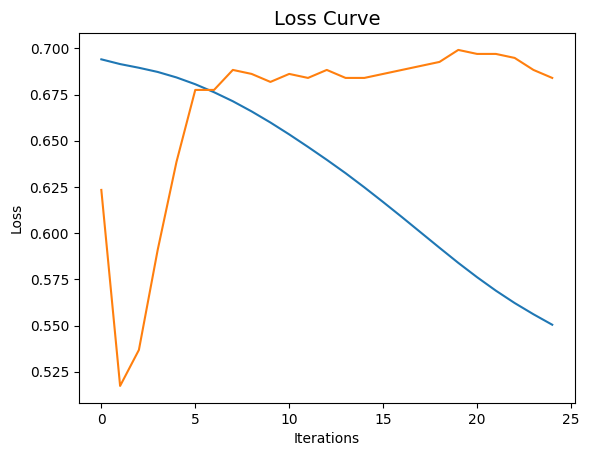

In [95]:
plt.plot(model.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.plot(model.validation_scores_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


In [96]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('Accuracy Test: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy Train: {:.2f}'.format(accuracy_score(y_train, y_pred_train)))


Accuracy Test: 0.67
Accuracy Train: 0.70


In [97]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels=[0, 1]))
print(classification_report(y_train, y_pred_train, labels=[0, 1]))


              precision    recall  f1-score   support

           0       0.65      0.71      0.68       321
           1       0.70      0.63      0.66       339

    accuracy                           0.67       660
   macro avg       0.67      0.67      0.67       660
weighted avg       0.67      0.67      0.67       660

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       779
           1       0.72      0.66      0.69       761

    accuracy                           0.70      1540
   macro avg       0.71      0.70      0.70      1540
weighted avg       0.70      0.70      0.70      1540



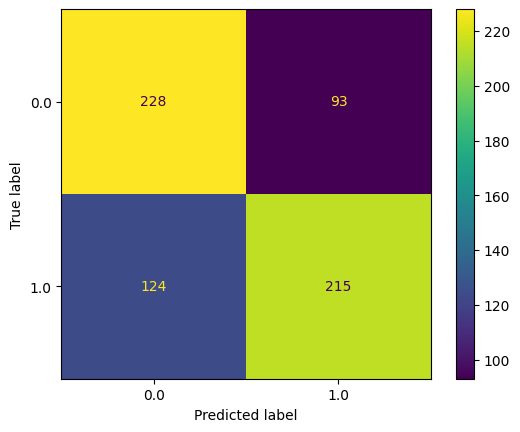

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, model.predict(X_test), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()


In [99]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

(0.729036289618541, 0.7694245629779073)

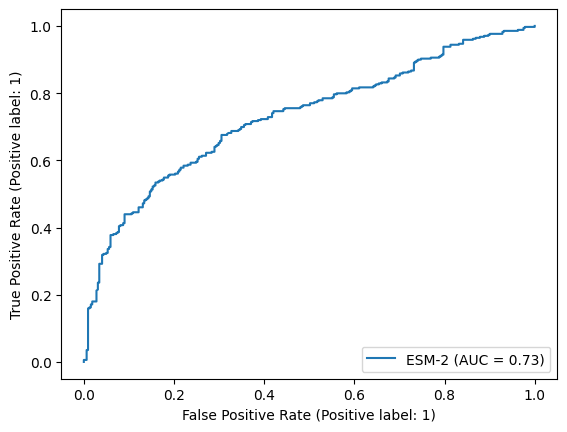

In [80]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(
    model, X_test, y_test, name="ESM-2", pos_label=1
)


In [169]:
from sklearn.model_selection import train_test_split
train_dna, test_dna = train_test_split(df_dna, test_size=0.3)
train_dna

,Entry,Sequence,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
152,Q9H2U1,MGKGVGRDKYEPAAVSEQGDKKGKKGKKDRDMDELKKEVSMDDHKL...,2.0,0.012285,-0.034064,-0.028018,0.002197,0.016307,0.041650,-0.062965,0.032150,0.070504,-0.040988,0.051738,0.079072,0.004036,-0.030204,0.060111,-0.041317,-0.019955,-0.017945,0.026639,-0.009750,-0.047415,-0.011330,0.101867,-0.008019,0.017226,0.003619,-0.021006,-0.054157,-0.030780,-0.019250,-1.170733e-02,0.109353,-0.134449,0.042297,-0.132742,0.054077,0.046328,...,0.017498,-0.076274,-0.025398,0.004647,-0.055301,0.013091,0.045352,0.027579,-0.030621,-0.052895,-0.006628,0.007273,-0.040027,-0.019650,-0.039969,-0.033473,-0.054316,-0.023175,0.004624,-0.024579,0.115568,0.063816,-0.007119,0.081118,-0.012660,0.012222,0.002397,-0.091123,0.065957,0.007303,-0.006862,0.003181,0.007827,-0.033380,0.024508,0.017463,-0.020570,0.026176,0.062871,-0.034481
57,Q00536,MDRMKKIKRQLSMTLRGGRGIDKTNGAPEQIGLDESGGGGGSDPGE...,0.0,0.059922,0.072352,0.030050,0.021944,-0.008484,0.042628,-0.009151,-0.034615,-0.028628,-0.017149,0.038459,-0.003051,-0.040310,0.014457,0.036137,0.021031,0.022056,-0.018797,-0.028630,-0.009154,-0.081587,-0.013798,0.087553,-0.031749,-0.051335,-0.008518,0.041961,-0.053033,-0.023190,0.021173,-4.306916e-07,0.068488,-0.112455,-0.037895,-0.122330,-0.014055,0.027867,...,0.018848,-0.012961,-0.044923,0.029423,-0.004960,0.017807,0.033648,-0.020488,0.033343,-0.005253,0.031806,-0.018715,-0.018823,-0.029754,0.017448,0.012324,0.011911,-0.010151,0.001857,0.033407,0.127860,-0.067207,0.001577,-0.008859,-0.019001,-0.034163,-0.011820,-0.007685,0.023998,-0.008227,-0.032242,-0.016260,-0.074719,0.006081,0.044762,-0.011330,-0.001795,0.012386,-0.009905,0.013275
122,Q9HCN6,MSPSPTALFCLGLCLGRVPAQSGPLPKPSLQALPSSLVPLEKPVTL...,0.0,0.020482,0.058074,0.072452,0.008620,-0.006216,0.052481,-0.049380,-0.037752,0.009301,-0.008237,0.036507,0.029107,-0.025742,-0.023928,0.056963,0.001524,-0.010905,-0.015164,-0.010650,-0.018971,-0.034456,-0.048393,0.037860,-0.041895,-0.007483,-0.051312,0.025962,-0.015767,-0.036912,0.000296,-2.420147e-02,0.086180,-0.114991,-0.002108,-0.119172,0.004426,0.024125,...,-0.005685,-0.004143,-0.035958,0.007984,-0.003214,0.014239,0.000253,0.047966,0.045053,0.028979,-0.009850,-0.033686,0.001879,-0.028316,0.035548,0.030587,0.011846,0.002873,-0.019675,-0.007258,0.126658,-0.048493,-0.003420,0.009028,0.008328,-0.004774,0.034547,0.021753,0.007674,-0.009972,-0.040509,-0.024926,-0.015472,0.034884,-0.006645,0.031019,0.021738,0.010637,-0.050961,-0.021347
33,Q96JG8,MAEGSFSVQSESYSVEDMDEGSDEVGEEEMVEGNDYEEFGAFGGYG...,0.0,0.027486,0.003951,0.025066,0.008062,0.009088,0.062834,-0.113945,-0.041242,0.089674,-0.024998,0.061492,0.031662,0.036159,-0.001016,-0.008791,-0.018658,-0.011798,-0.050503,0.004298,-0.048826,0.006683,0.037949,0.092292,-0.004754,0.056011,0.003926,0.000235,-0.029888,0.024891,0.009415,5.659044e-03,0.048275,-0.141865,-0.017264,-0.133934,0.027400,-0.004744,...,0.025843,-0.005241,-0.062990,0.021737,-0.036790,-0.010794,-0.020912,0.012234,0.019713,-0.037230,-0.013193,0.030355,-0.032965,-0.038436,-0.072423,-0.020901,-0.005392,-0.042856,-0.005949,-0.012280,0.126795,0.010019,0.032487,0.014987,-0.028503,0.005291,-0.010648,-0.020389,-0.012715,-0.005663,-0.037057,-0.035132,0.006534,0.033582,0.052843,0.029919,-0.032902,-0.009097,0.038946,0.039100
124,Q7Z6K1,MPRYCAAICCKNRRGRNNKDRKLSFYPFPLHDKERLEKWLKNMKRD...,0.0,-0.052158,0.012132,0.021867,0.029866,-0.029103,0.052208,-0.047174,-0.058851,0.047270,0.088014,-0.032850,-0.037302,0.089643,-0.012918,0.100324,-0.047554,-0.029347,0.033641,-0.000839,0.006198,-0.007885,0.005945,-0.055960,-0.042356,0.086546,0.026045,0.005412,0.006178,0.001419,-0.004579,1.967468e-02,0.124472,-0.124629,0.027370,-0.129446,-0.018904,-0.037514,...,0.043782,-0.009531,-0.049176,-0.004392,-

In [218]:
y_train_dna = train_dna['target']
X_train_dna = train_dna.iloc[:, 3:]
y_test_dna = test_dna['target']
X_test_dna = test_dna.iloc[:, 3:]

In [171]:
X_test_dna

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
139,0.065266,0.074600,0.044333,-0.009560,0.007003,0.076570,-0.032165,-0.085835,-0.038765,0.010784,-0.035015,-0.035091,0.031580,0.041964,0.034264,0.000740,0.047774,-0.072666,-0.037223,-0.018059,-0.039940,-0.014683,0.041997,-0.034815,-0.038443,0.015439,0.037014,-0.030072,0.003583,0.011758,0.025778,0.133717,-0.106899,-0.092304,-0.114035,0.011709,-0.009657,-0.013585,-0.005867,0.075720,...,0.022066,-0.007492,-0.069956,-0.003880,0.033773,0.012055,-0.006844,-0.094979,0.060728,0.003461,0.021590,-0.059067,-0.021538,-0.044850,0.061539,-0.031251,-0.002257,0.019942,-0.021810,0.018709,0.120985,-0.031385,0.052389,0.007878,0.001535,-0.054854,-0.001823,-0.001173,0.052239,0.011170,-0.042875,-0.041847,-0.065661,0.004882,-0.041400,-0.027584,-0.030134,-0.038431,0.007025,0.125590
9,0.074932,0.068855,0.047589,-0.073095,0.025882,0.017842,0.015104,-0.056362,0.026431,-0.010743,0.016880,-0.029098,0.003541,-0.028361,0.078243,-0.021491,0.016706,-0.028406,-0.027487,-0.001229,-0.028552,-0.035993,0.003508,0.015886,-0.016860,-0.012528,0.031352,0.000264,0.016957,0.001434,0.014729,0.091081,-0.138924,0.005260,-0.126128,0.060256,-0.024244,-0.051688,0.021989,0.020524,...,0.030833,-0.034265,-0.056662,0.030298,0.025124,0.014494,-0.015123,-0.027559,-0.003646,0.088135,0.028348,-0.043002,0.038350,-0.012703,0.001386,-0.007119,0.026483,0.053872,0.032088,-0.065147,0.131790,0.021281,-0.023495,-0.013933,-0.016057,0.061457,0.011998,0.002688,0.014222,0.012643,-0.060436,0.004342,0.005868,-0.013275,0.002906,-0.080617,-0.074420,-0.064474,0.041893,0.012406
155,-0.031816,-0.055067,0.002781,0.011213,-0.017170,0.033942,0.004976,-0.031336,0.060243,0.012221,0.012468,-0.036517,0.051262,0.000889,0.024062,-0.018815,0.011921,0.014340,-0.006537,-0.016708,-0.032287,-0.023251,-0.003161,0.007627,0.024373,0.004659,-0.037055,-0.030854,-0.043369,0.000565,-0.008377,0.075616,-0.138486,-0.018061,-0.127553,-0.010334,0.001440,0.014196,0.040707,0.019843,...,-0.024558,-0.029171,-0.005902,0.031383,0.008662,0.012375,0.025702,-0.003356,0.005597,0.009788,0.011994,0.002202,-0.023660,-0.036963,-0.021516,0.004161,0.048146,0.007729,-0.013372,-0.004486,0.130286,0.033625,0.048430,0.029614,-0.003058,0.054336,-0.030209,-0.067637,-0.060139,-0.017723,-0.030893,-0.038694,0.022177,-0.006951,-0.022743,-0.003121,-0.047606,-0.007017,0.018031,0.046825
174,0.065266,0.074600,0.044333,-0.009560,0.007003,0.076570,-0.032165,-0.085835,-0.038765,0.010784,-0.035015,-0.035091,0.031580,0.041964,0.034264,0.000740,0.047774,-0.072666,-0.037223,-0.018059,-0.039940,-0.014683,0.041997,-0.034815,-0.038443,0.015439,0.037014,-0.030072,0.003583,0.011758,0.025778,0.133717,-0.106899,-0.092304,-0.114035,0.011709,-0.009657,-0.013585,-0.005867,0.075720,...,0.022066,-0.007492,-0.069956,-0.003880,0.033773,0.012055,-0.006844,-0.094979,0.060728,0.003461,0.021590,-0.059067,-0.021538,-0.044850,0.061539,-0.031251,-0.002257,0.019942,-0.021810,0.018709,0.120985,-0.031385,0.052389,0.007878,0.001535,-0.054854,-0.001823,-0.001173,0.052239,0.011170,-0.042875,-0.041847,-0.065661,0.004882,-0.041400,-0.027584,-0.030134,-0.038431,0.007025,0.125590
115,0.048466,0.073131,0.014307,0.013577,-0.012742,0.061491,-0.074406,-0.027555,-0.004181,0.020025,0.032817,0.013451,-0.002817,0.004184,0.011900,-0.008658,0.003473,0.023665,0.014600,-0.031193,-0.017424,-0.020701,0.097164,-0.018115,-0.036584,0.007095,-0.010166,-0.033581,-0.027897,-0.003191,0.011266,0.112122,-0.125107,0.017494,-0.127123,-0.000080,0.019306,0.023859,0.003946,0.035849,...,0.017718,0.000820,-0.035137,0.019124,0.003509,0.026207,0.031263,-0.008262,0.031432,0.013322,-0.014165,0.015409,-0.045802,-0.028150,-0.014822,0.007190,0.013775,-0.006182,0.040708,0.006174,0.127645,-0.022457,0.018061,0.027484,-0.016876,-0.003512,0.0

In [209]:
params = {'activation': 'relu',
  'hidden_layer_sizes': [64, 64, 64, 64, 64],
  'learning_rate': 'constant',
  'solver': 'adam'}

model = MLPClassifier(
    max_iter=40,
    early_stopping=True,
    validation_fraction=0.3,
    random_state=42,
    n_iter_no_change=1000,
    batch_size=int(1e9),
    # batch_size=5,
    **params
)

model.fit(X_train_dna,y_train_dna)
print("  Activation Function: %s" % model.activation)
print("   Hidden Layer Sizes: %s" % model.hidden_layer_sizes)
print("                Alpha: %f" % model.alpha)
y_pred = model.predict(X_test_dna)
print("             Accuracy: %f" % accuracy_score(y_test_dna, y_pred))


  Activation Function: relu
   Hidden Layer Sizes: [64, 64, 64, 64, 64]
                Alpha: 0.000100
             Accuracy: 0.750000


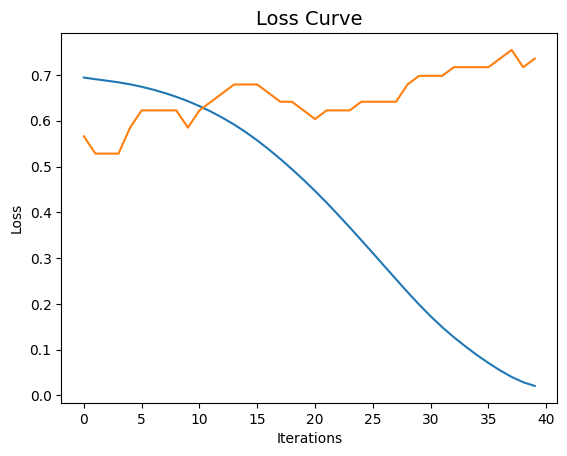

In [210]:
plt.plot(model.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.plot(model.validation_scores_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


In [211]:
y_pred = model.predict(X_test_dna)
y_pred_train = model.predict(X_train_dna)

print('Accuracy Test: {:.2f}'.format(accuracy_score(y_test_dna, y_pred)))
print('Accuracy Train: {:.2f}'.format(accuracy_score(y_train_dna, y_pred_train)))


Accuracy Test: 0.75
Accuracy Train: 0.93


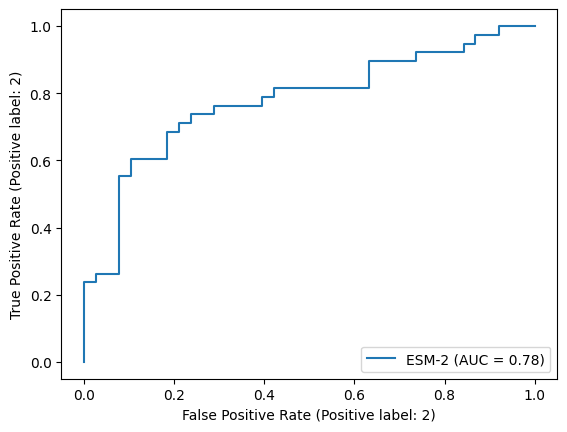

In [212]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(
    model, X_test_dna, y_test_dna, name="ESM-2", pos_label=2
)


In [213]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_test_dna, model.predict_proba(X_test_dna)[:, 1])

0.7770083102493075

In [219]:
from sklearn.model_selection import train_test_split
train_all, test_all = train_test_split(df_all, test_size=0.3)


In [220]:
y_train_all = train_all['target']
X_train_all = train_all.iloc[:, 3:]
y_test_all = test_all['target']
X_test_all = test_all.iloc[:, 3:]

In [107]:
params = {'activation': 'relu',
  'hidden_layer_sizes': [512, 256, 128, 64, 32],
  'learning_rate': 'constant',
  'solver': 'adam'}

model = MLPClassifier(
    max_iter=3000,
    early_stopping=True,
    validation_fraction=0.4,
    random_state=42,
    n_iter_no_change=100,
    batch_size=int(1e9),
    **params
)

model.fit(X_train_all,y_train_all)
print("  Activation Function: %s" % model.activation)
print("   Hidden Layer Sizes: %s" % model.hidden_layer_sizes)
print("                Alpha: %f" % model.alpha)
y_pred = model.predict(X_test_all)
print("             Accuracy: %f" % accuracy_score(y_test_all, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


  Activation Function: relu
   Hidden Layer Sizes: [512, 256, 128, 64, 32]
                Alpha: 0.000100
             Accuracy: 0.645380


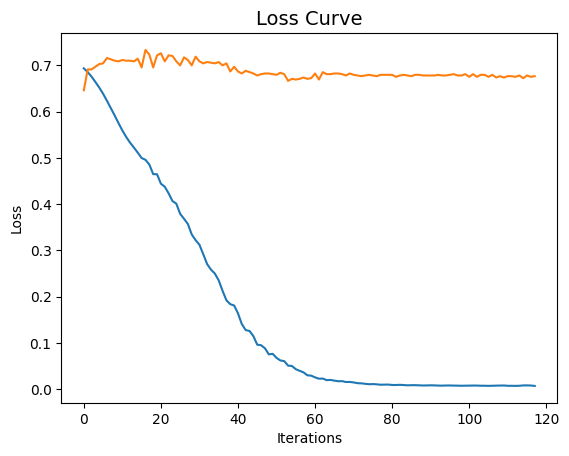

In [108]:
plt.plot(model.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.plot(model.validation_scores_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


In [109]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_test_all, model.predict_proba(X_test_all)[:, 1])

0.7111020022304448

In [221]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import pyplot

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [224]:
sum(y_train_all == 2)

0

In [235]:
xgb = XGBClassifier(objective= 'binary:logistic')
# y_train_dna = y_train_dna.apply(lambda x: int(bool(x)))
xgb.fit(X_train_all, y_train_all)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [236]:
preds_train = xgb.predict(X_train_all)
preds_test = xgb.predict(X_test_all)
print('XGBoosting:\n> Accuracy on training data = {:.4f}\n> Accuracy on validation data = {:.4f}'.format(
    accuracy_score(y_true=y_train_all, y_pred=preds_train),
    accuracy_score(y_true=y_test_all, y_pred=preds_test)
))
roc_auc_score(y_test_all, xgb.predict_proba(X_test_all)[:, 1])

XGBoosting:
> Accuracy on training data = 0.9971
> Accuracy on validation data = 0.6535


0.715159141376758

In [227]:
eval_set = [(X_test_all, y_test_all)]
xgb = XGBClassifier(objective= 'binary:logistic', eval_metric=roc_auc_score)

xgb.fit(X_train_all, y_train_all, early_stopping_rounds=100, eval_set=eval_set, verbose=True)

preds_test = xgb.predict(X_test_all)

roc_auc_score(y_test_all, xgb.predict_proba(X_test_all)[:, 1])

[0]	validation_0-logloss:0.66380	validation_0-roc_auc_score:0.64185
[1]	validation_0-logloss:0.65356	validation_0-roc_auc_score:0.66072
[2]	validation_0-logloss:0.65387	validation_0-roc_auc_score:0.66509
[3]	validation_0-logloss:0.64720	validation_0-roc_auc_score:0.67994
[4]	validation_0-logloss:0.64838	validation_0-roc_auc_score:0.68397
[5]	validation_0-logloss:0.64637	validation_0-roc_auc_score:0.69133
[6]	validation_0-logloss:0.64943	validation_0-roc_auc_score:0.69586
[7]	validation_0-logloss:0.64962	validation_0-roc_auc_score:0.69895
[8]	validation_0-logloss:0.65283	validation_0-roc_auc_score:0.70073
[9]	validation_0-logloss:0.65925	validation_0-roc_auc_score:0.69951
[10]	validation_0-logloss:0.66825	validation_0-roc_auc_score:0.69777
[11]	validation_0-logloss:0.67410	validation_0-roc_auc_score:0.69837
[12]	validation_0-logloss:0.68190	validation_0-roc_auc_score:0.69670
[13]	validation_0-logloss:0.68432	validation_0-roc_auc_score:0.69762
[14]	validation_0-logloss:0.68827	validation

0.6418467801628425

In [237]:
roc_auc_score(y_test_all, xgb.predict_proba(X_test_all)[:, 1])

0.715159141376758

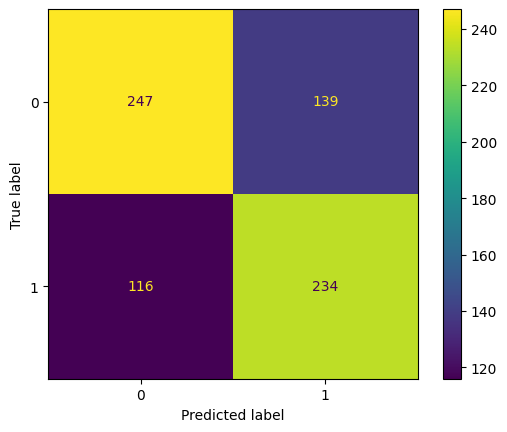

In [238]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test_all, preds_test, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb.classes_)
disp.plot()
plt.show()


In [239]:
print(xgb.feature_importances_)
print()
print('Length of feature_importances_ list: ' + str(len(xgb.feature_importances_)))
print()
print('Number of predictors in X_train_all: ' + str(X_train_all.shape[1]))


[9.6352873e-05 0.0000000e+00 0.0000000e+00 ... 2.6462562e-03 5.5811094e-04
 0.0000000e+00]

Length of feature_importances_ list: 1024

Number of predictors in X_train_all: 1024


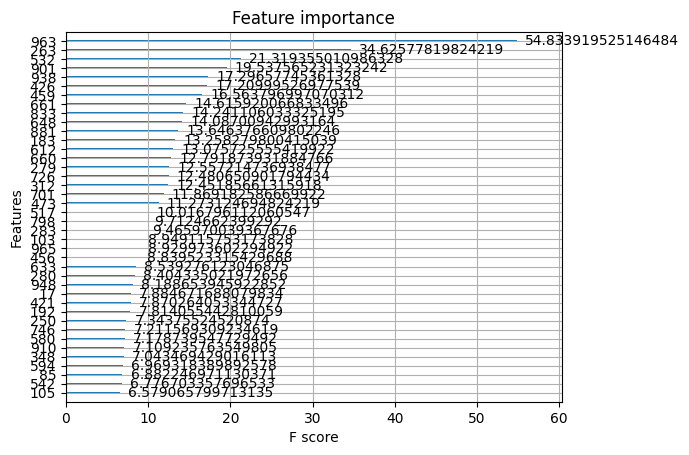

In [240]:
plot_importance(xgb, max_num_features=40, importance_type='gain')
pyplot.show()


In [241]:
feature_names = X_train_all.columns

feature_importance_df = pd.DataFrame(xgb.feature_importances_, feature_names)
feature_importance_df = feature_importance_df.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df


,Feature,Importance
0,0,0.000096
1,1,0.000000
2,2,0.000000
3,3,0.000339
4,4,0.000201
...,...,...
1019,1019,0.000190
1020,1020,0.002170
1021,1021,0.002646
1022,1022,0.000558


In [242]:
feature_importance_df_top_50 = feature_importance_df.sort_values(by='Importance', ascending=False).head(200)
feature_importance_df_top_50


,Feature,Importance
963,963,0.031815
263,263,0.020090
532,532,0.012370
901,901,0.011336
938,938,0.010036
...,...,...
415,415,0.001624
706,706,0.001593
397,397,0.001587
253,253,0.001585


<BarContainer object of 200 artists>

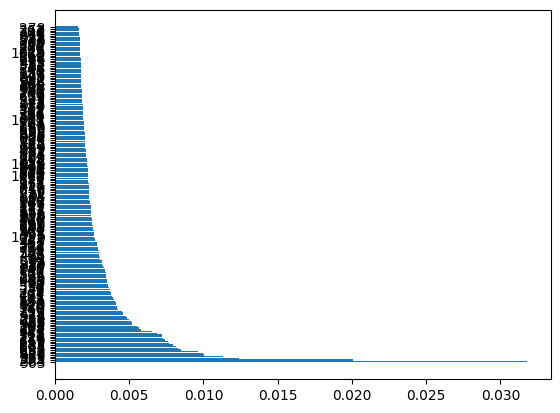

In [243]:
plt.barh(feature_importance_df_top_50.Feature, feature_importance_df_top_50.Importance)



Length of remaining predictors after XGB: 864


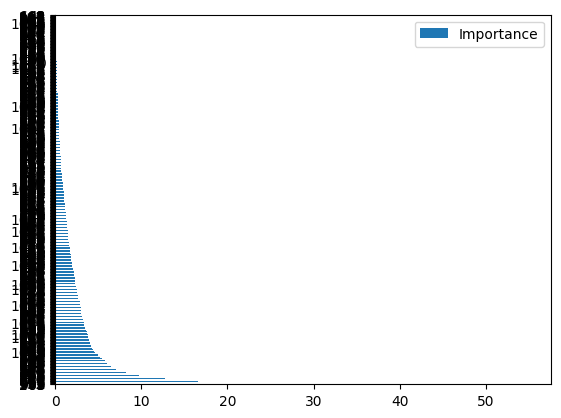

In [244]:
features_selected_from_XGBoost = xgb.get_booster().get_score(importance_type='gain')
keys = list(features_selected_from_XGBoost.keys())
values = list(features_selected_from_XGBoost.values())

features_selected_from_XGBoost = pd.DataFrame(data=values, 
                                              index=keys, 
                                              columns=["Importance"]).sort_values(by = "Importance", 
                                                                             ascending=False)
features_selected_from_XGBoost.plot(kind='barh')

print()
print('Length of remaining predictors after XGB: ' + str(len(features_selected_from_XGBoost)))


In [245]:
print(feature_importance_df[(feature_importance_df["Importance"] == 0)])
print()
print('Length of features with Importance = zero:  ' + str(feature_importance_df[(feature_importance_df["Importance"] == 0)].shape[0] ))


     Feature  Importance
1          1         0.0
2          2         0.0
10        10         0.0
13        13         0.0
24        24         0.0
...      ...         ...
978      978         0.0
1003    1003         0.0
1006    1006         0.0
1016    1016         0.0
1023    1023         0.0

[160 rows x 2 columns]

Length of features with Importance = zero:  160


In [251]:
top_50_of_retained_features_from_model = features_selected_from_XGBoost.sort_values(by='Importance', ascending=False).head(50)

xgb = XGBClassifier(objective= 'binary:logistic')
xgb.fit(X_train_dna[top_50_of_retained_features_from_model.index], y_train_dna)

roc_auc_score(y_test_dna, xgb.predict_proba(X_test_dna[top_50_of_retained_features_from_model.index])[:, 1])

0.8476454293628809